In [2]:

# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False)
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

# Point Cloud Classification with Graph Neural Networks 

## Data Handling

The `GeometricShapes` dataset contains 40 different 2D and 3D geometric shapes such as cubes, spheres and pyramids.
There exists two different versions of each shape, and one is used for training the neural network and the other is used to evaluate its performance.

GeometricShapes(40)
Data(face=[3, 30], pos=[32, 3], y=[1])


<ipython-input-2-0e2fb88bab04>:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


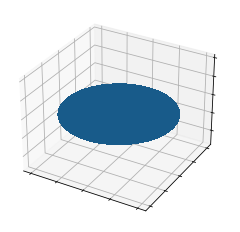

Data(face=[3, 2], pos=[4, 3], y=[1])


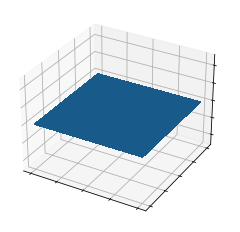

In [3]:
from torch_geometric.datasets import GeometricShapes

dataset = GeometricShapes(root='data/GeometricShapes')
print(dataset)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

PyTorch Geometric을 통해 'GeometricShapes' 데이터 세트를 쉽게 가져오고 인스턴스화할 수 있으며, *예: 데이터셋 설명 또는 단일 예에 포함된 특성에 대한 일부 정보를 *예:* 인쇄할 수 있습니다.
특히 각 객체는 **메시**로 표현되며, 'pos'의 정점과 'face'의 정점 삼각형 연결성에 대한 정보를 담고 있습니다('[3, num_faces]' 모양).

## Point Cloud Generation

point cloud 분류에 집중하자면, transformation을 사용하여, mesh를 point로 변활할 수 있습니다. (SamplePoints)

* SamplePoints
    * 면적에 따라 메시 면의 고정된 개수의 점을 균일하게 샘플링합니다.
* dataset.dataset = SamplePoints(num=...)를 통해 설정하기만 하면 이 변환을 데이터셋에 추가할 수 있습니다. *
    * 데이터셋에서 예제에 액세스할 때마다 변환 절차를 다음과 같이 부릅니다.



Data(pos=[256, 3], y=[1])


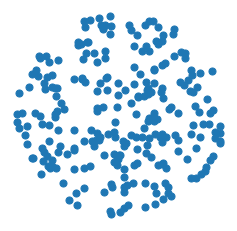

Data(pos=[256, 3], y=[1])


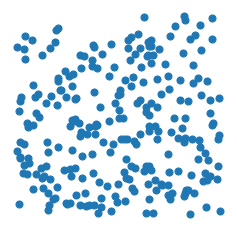

In [4]:
import torch
from torch_geometric.transforms import SamplePoints

torch.manual_seed(42)

dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

data = dataset[4]
print(data)
visualize_points(data.pos)

## PointNet++

이제 포인트 클라우드 데이터 세트를 사용할 준비가 되었으므로 그래프 뉴럴 네트워크를 통해 데이터를 처리하는 방법과 PyTorch Geometric 라이브러리의 도움을 살펴보겠습니다.

PointNet++ 프로세스는 간단한 그룹화, 인접 통합 및 다운샘플링 체계를 따라 반복적으로 클라우드를 포인트화합니다.

1. **그룹화 단계(grouping phase)**는 주변 지점들이 연결되는 그래프를 생성합니다. 일반적으로 이 작업은 $k$-nearest neighbor 검색 또는 볼 쿼리(반경 내의 모든 포인트를 쿼리 포인트에 연결)를 통해 수행됩니다.


2. **근린집계 단계(neighborhood aggregation phase)**는 각 지점마다 직접 인접 지점으로부터 정보를 취합하는 Graph Neural Network 계층을 실행합니다(이전 단계에서 구성된 그래프로 제공).
이를 통해 PointNet++는 서로 다른 척도의 로컬 컨텍스트를 캡처할 수 있습니다.


3. **다운샘플링 단계(downsampling phase)**는 크기가 서로 다른 포인트 클라우드에 적합한 풀링 방식을 구현합니다. 우리는 현재로서는 이 단계를 무시하고 나중에 다시 시작할 것이다.

### Phase 1: Grouping via Dynamic Graph Generation

dynamic graph 생성을 위해서 pytorch_cluster를 제공한다. (knn_graph) , (radius_graph)

여기서 torch_cluster에서 knn_graph 함수를 가져와 pos 입력 지점과 가장 가까운 이웃의 수 k를 입력하여 호출합니다.

출력으로, 우리는 각 열에 소스 및 대상 노드 지수의 정보를 보관하는 "[2, num_edges]" 모양의 'edge_index' 텐서를 받을 것이다(스파스 매트릭스 COO 포맷으로 알려져 있음).


torch.Size([2, 1536])


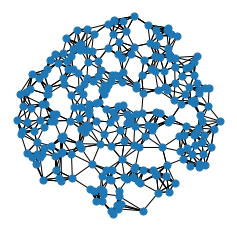

torch.Size([2, 1536])


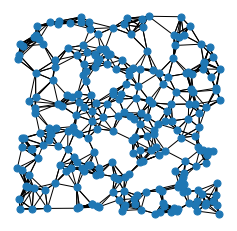

In [5]:
from torch_cluster import knn_graph

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[4]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

## Phase 2: Neighborhood Aggregation

The **[PointNet++](https://arxiv.org/abs/1706.02413) layer** follows a simple *neural message passing scheme* defined via


$$
\mathbf{h}^{(\ell + 1)}_i = \max_{j \in \mathcal{N}(i)} \textrm{MLP} \left( \mathbf{h}_j^{(\ell)}, \mathbf{p}_j - \mathbf{p}_i \right)
$$
where
* $\mathbf{h}_i^{(\ell)} \in \mathbb{R}^d$ denotes the hidden features of point $i$ in layer $\ell$
* $\mathbf{p}_i \in \mathbb{R}^3$ denotes the position of point $i$.


MessagePassing interface to implement this layer. 

MessagePassing interface는 메시지 전달을 자동으로 관리하여 메시지 전달 그래프 신경 네트워크를 만드는 데 도움이 됩니다.

여기서는 message function과 사용할 집계 체계(예: aggr="max")만 정의하면 됩니다.

In [6]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super(PointNetLayer, self).__init__('max')
        
        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(Linear(in_channels + 3, out_channels),
                              ReLU(),
                              Linear(out_channels, out_channels))
        
    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)
    
    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

In [7]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)
        
    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)
        
        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]
        
        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer(
    (mlp): Sequential(
      (0): Linear(in_features=6, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (conv2): PointNetLayer(
    (mlp): Sequential(
      (0): Linear(in_features=35, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [9]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.data import DataLoader

train_dataset = GeometricShapes(root='data/GeometricShapes', train=True,
                                transform=SamplePoints(128))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=SamplePoints(128))


train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
class Printer():
    """Print things to stdout on one line dynamically"""
    def __init__(self,num_period=10):
        self.num_period = num_period
        self.init_value = 0

    def __call__(self,data) :
        if self.init_value % self.num_period == 0 :
            print('\n'+data.__str__())
            self.init_value = 1
        else :
            sys.stdout.write("\r\x1b[K"+data.__str__())
            sys.stdout.flush()
            self.init_value += 1 
            
printf = Printer(num_period=50)
                    
def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(logits, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 51):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    printf(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>


Epoch: 01, Loss: 3.7449, Test Accuracy: 0.0500
Epoch: 50, Loss: 0.8994, Test Accuracy: 0.6750

Data(face=[3, 30], pos=[32, 3], y=[1])


<ipython-input-2-0e2fb88bab04>:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


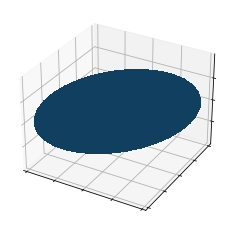

Data(face=[3, 2], pos=[4, 3], y=[1])


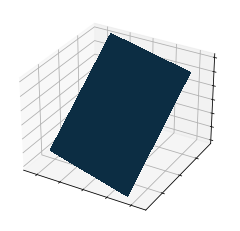

In [10]:
from torch_geometric.transforms import Compose, RandomRotate

torch.manual_seed(123)

random_rotate = Compose([
    RandomRotate(degrees=180, axis=0),
    RandomRotate(degrees=180, axis=1),
    RandomRotate(degrees=180, axis=2),
])

dataset = GeometricShapes(root='data/GeometricShapes', transform=random_rotate)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

In [11]:
torch.manual_seed(42)

transform = Compose([
    random_rotate,
    SamplePoints(num=128),
])

test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=transform)

test_loader = DataLoader(test_dataset, batch_size=10)

test_acc = test(model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.1750


In [12]:
from torch_geometric.nn import PPFConv
from torch_cluster import fps


class PPFNet(torch.nn.Module):
    def __init__(self):
        super(PPFNet, self).__init__()

        torch.manual_seed(12345)
        mlp1 = ...  # TODO
        self.conv1 = PPFConv(...)  # TODO
        mlp2 = ...  # TODO
        self.conv2 = PPFConv(...)  # TODO
        self.classifier = Linear(32, dataset.num_classes)
        
    def forward(self, pos, normal, batch):
        edge_index = knn_graph(pos, k=16, batch=batch, loop=False)
        
        x = self.conv1(x=None, pos=pos, normal=normal, edge_index=edge_index)
        x = x.relu()
        x = self.conv2(x=x, pos=pos, normal=normal, edge_index=edge_index)
        x = x.relu()

        x = global_max_pool(x, batch)  # [num_examples, hidden_channels]
        return self.classifier(x)


model = PPFNet()
print(model)

PPFNet(
  (conv1): PPFConv(local_nn=Ellipsis, global_nn=None)
  (conv2): PPFConv(local_nn=Ellipsis, global_nn=None)
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [15]:

test_transform = Compose([
    random_rotate,
    SamplePoints(num=128, include_normals=True),
])

train_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=SamplePoints(128, include_normals=True))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PPFNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.normal, data.batch)
        loss = criterion(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.normal, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 101):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    printf(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

TypeError: 'ellipsis' object is not callable

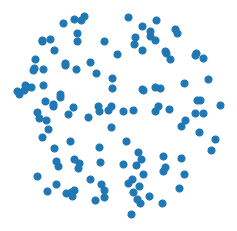

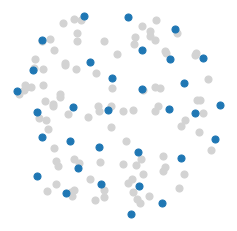

In [14]:
from torch_cluster import fps

dataset = GeometricShapes(root='data/GeometricShapes', transform=SamplePoints(128))

data = dataset[0]
index = fps(data.pos, ratio=0.25)

visualize_points(data.pos)
visualize_points(data.pos, index=index)